<a href="https://colab.research.google.com/github/xr-cc/proj-hsg-env-chal/blob/master/code/spatial_cross_corr_income_CES3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial correlation analysis of important variables in CES3 Bay Area data, with income and seismic data incorporated

Follow the tutorial in http://darribas.org/gds_scipy16/ipynb_md/04_esda.html.


In [ ]:
! pip install geopandas
! pip install descartes
! pip install mapclassify
! pip install libpysal
! pip install esda

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

# import pysal as ps
# from pysal.contrib.viz import mapping as maps

import mapclassify as mc
import libpysal as lps
from esda.moran import Moran,Moran_Local

from matplotlib import colors

In [112]:
from scipy.spatial.distance import pdist,squareform
from sklearn.metrics import r2_score

In [3]:
# grant access to Google Drive
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# os.listdir("/content/drive/My Drive/")
from google.colab import files

In [5]:
# load data

dataPath = "/content/drive/My Drive/DS4A/DS4A_Team 31/data/CES3/"
xls = pd.ExcelFile(dataPath+"CES3, income brackets, seismic - Bay Area.xlsx")
sheets = xls.sheet_names
print(sheets)


['CES 3.0 (2018 Update)', 'Income cutoffs per county', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


In [6]:
# load dataframes

df = pd.read_excel(xls, sheet_name=sheets[0])
df_dict = pd.read_excel(xls, sheet_name=sheets[2],skiprows=range(0,6)).dropna(thresh=2)
df_demo = pd.read_excel(xls, sheet_name=sheets[4], header=None,
                        names=['Census Tract','CES 3.0 Score','CES 3.0 Percentile','CES 3.0 Percentile Range','Total Population',
                               'California County','Age:<10','Age:11-64','Age:>65', 'Race:Hispanic','Race:White','Race:AfricanAmerican',
                               'Race:NativeAmerican','Race:Aisan','Race:Other'],skiprows=[0]).dropna()

df_dict_temp = df_dict.dropna()
# var_char = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Population')]['Variable Name'].drop_duplicates()
# var_char = [v.rstrip() for v in var_char]
# var_char.insert(0,'Census ID')
# print(var_char)

# load geo dataframe
gdf = gpd.read_file(dataPath+"CES3June2018Update.shp")
gdf = gdf[gdf['tract'].isin(df['Census ID'])].reset_index(drop=True).rename(columns={'tract': 'Census ID'})

# join dataframes
gdf = gdf.merge(df, on='Census ID')

In [7]:
gdf.head()

,Census ID,pop2010,California,ZIP_x,City,Longitude_x,Latitude_x,CIscore,CIscoreP,ozone,ozoneP,pm,pmP,diesel,dieselP,drink,drinkP,pest,pestP,RSEIhaz,RSEIhazP,traffic,trafficP,cleanups,cleanupsP,gwthreats,gwthreatsP,haz,hazP,iwb,iwbP,swis,swisP,Pollution,PollutionS,PollutionP,asthma,asthmaP,lbw,lbwP,...,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6.085509e+09,4603,Santa Clara,94043,Mountain View,-122.074346,37.401206,19.89,38,0.035,17,9.96,43,28.58,83,277.40,29,0.000,0,252.02,40,1230.83,76,66.5,98,121.85,98,0.20,61,5,55,0.0,0,48.16,5.93,67,20.70,9,4.77,46,...,277.402571,28.701509,0.000000,0.000000,252.024338,40.296832,1230.83,76.212558,66.5,97.756293,121.85,98.013903,0.200,60.500463,5,55.007738,0.0,0.0,48.161547,5.932202,67.330429,20.70,8.839297,4.77,45.802896,6.48,30.270540,5.0,19.707292,4.6,33.902146,10.5,7.806411,9.9,55.298896,21.5,65.143437,32.337940,3.353660,23.054610
1,6.085510e+09,4688,Santa Clara,94022,Los Altos,-122.120112,37.392783,3.53,1,0.035,17,9.96,43,19.90,61,465.27,48,0.056,16,202.20,36,566.07,38,6.9,50,17.10,66,0.06,28,0,0,0.0,0,34.30,4.23,30,9.01,0,2.63,6,...,465.266900,47.561432,0.055507,16.412742,202.201348,36.118733,566.07,37.974684,6.9,50.474279,17.10,65.921880,0.060,28.044486,0,0.000000,0.0,0.0,34.304607,4.225401,30.105787,9.01,0.423887,2.63,5.549148,3.43,1.882558,2.4,7.418622,2.2,15.677910,5.8,1.759899,3.5,4.251809,15.7,38.461538,8.066243,0.836523,0.731492
2,6.085509e+09,3212,Santa Clara,94306,Palo Alto,-122.114454,37.406981,7.97,8,0.035,17,9.54,41,23.86,73,491.91,52,0.000,0,205.50,37,633.51,45,5.3,45,16.50,65,0.00,0,0,0,0.0,0,32.50,4.00,26,9.79,1,3.75,21,...,491.909027,52.276413,0.000000,0.000000,205.502860,36.530307,633.51,44.742449,5.3,45.220722,16.50,64.581264,0.000,0.000000,0,0.000000,0.0,0.0,32.499793,4.003097,25.550716,9.79,0.610896,3.75,20.889402,3.16,1.009849,3.8,14.042392,13.4,70.590588,15.2,16.668762,5.2,14.151542,15.8,39.083524,19.205372,1.991725,7.478875
3,6.085509e+09,3706,Santa Clara,94043,Mountain View,-122.092278,37.406030,17.20,31,0.035,17,9.54,41,23.86,73,277.40,29,0.000,0,225.06,39,493.52,30,44.2,95,30.85,82,0.02,16,4,49,0.0,0,37.86,4.66,39,21.29,10,3.85,23,...,277.402571,28.701509,0.000000,0.000000,225.063625,38.600649,493.52,30.078957,44.2,95.147756,30.85,82.224429,0.025,15.681186,4,48.795048,0.0,0.0,37.858312,4.663122,39.439950,21.29,9.712006,3.85,22.952710,6.69,33.038275,10.4,40.625789,19.7,83.922144,29.3,43.570082,7.3,32.097982,17.1,45.925362,35.564634,3.688290,27.922815
4,6.085503e+09,4311,Santa Clara,95122,San Jose,-121.822135,37.331408,32.60,64,0.038,22,10.37,53,26.11,79,639.64,72,0.000,0,175.02,33,915.85,63,4.5,42,3.00,22,0.10,43,0,0,0.0,0,37.84,4.66,39,56.72,65,5.34,62,...,639.641415,71.984533,0.000000,0.000000,175.022211,33.462210,915.85,63.316205,4.5,42.174389,3.00,21.880172,0.100,43.113994,0,0.000000,0.0,0.0,37.837785,4.660593,39.315495,56.72,65.178905,5.34,61.771114,10.84,81.885052,34.2,81.112793,15.1,74.656712,31.5,47.165305,12.9,75.517198,17.5,47.994415,67.450487,6.995065,76.415689


In [8]:
df.columns

Index(['County', 'INDEPENDENT BRACKET: Less than $25,000 household income',
       '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999',
       '$100,000 or More',
       'CUMULATIVE: Percentage of households with income Less than $50,000',
       'Less than $60,000', 'Less than $75,000', 'Less than $100,000',
       'Census ID', 'Census Tract', 'Total Population', 'Unnamed: 13',
       'California County', 'ZIP',
       'Nearby City \n(to help approximate location only)', 'SEISMIC PGA',
       'Longitude', 'Latitude', 'CES 3.0 Score', ' CES 3.0 Percentile',
       'CES 3.0 \nPercentile Range', 'SB 535 Disadvantaged Community', 'Ozone',
       'Ozone Pctl', 'PM2.5', 'PM2.5 Pctl', 'Diesel PM', 'Diesel PM Pctl',
       'Drinking Water', 'Drinking Water Pctl', 'Pesticides',
       'Pesticides Pctl', 'Tox. Release', 'Tox. Release Pctl', 'Traffic',
       'Traffic Pctl', 'Cleanup Sites', 'Cleanup Sites Pctl',
       'Groundwater Threats', 'Groundwater Threats Pctl', 'Haz. Waste'

In [9]:
income_col = df.columns[1:10]
popchar_col = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Population')]['Variable Name'].drop_duplicates()
popchar_col = [v.rstrip() for v in popchar_col]
polbur_col = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Pollution')]['Variable Name'].drop_duplicates()
polbur_col = [v.rstrip() for v in polbur_col]
seismic_col = 'SEISMIC PGA'

In [10]:
income_col

Index(['INDEPENDENT BRACKET: Less than $25,000 household income',
       '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999',
       '$100,000 or More',
       'CUMULATIVE: Percentage of households with income Less than $50,000',
       'Less than $60,000', 'Less than $75,000', 'Less than $100,000'],
      dtype='object')

### Spatial Cross-Correlation

> Chen Y (2015) A New Methodology of Spatial Cross-Correlation Analysis. PLoS ONE 10(5): e0126158. https://doi.org/10.1371/journal.pone.0126158



In [202]:
var1 = 'PM2.5'
var2 = 'Asthma'
vars = [var1,var2]
gdf_vars = gdf.dropna(subset=vars)
# w = lps.weights.Queen.from_dataframe(gdf_vars)
# Wmatrix, ids = w.full()
x = np.array(gdf_vars[var1])
y = np.array(gdf_vars[var2])
# standardize
x = (x - np.mean(x)) / np.std(x)
y = (y - np.mean(y)) / np.std(y)
# expand dimensions
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

In [203]:
# pairwise distance between coordinates of areas
gdf_vars_loc = gdf_vars[['Longitude_x','Latitude_x']]
dist_mat = squareform(pdist(gdf_vars_loc))
n = len(dist_mat)
# contiguity: inverse power
contiguity_mat = 1/(np.identity(n)+dist_mat)-np.identity(n)
contiguity_mat = contiguity_mat/np.sum(contiguity_mat) # standardize

# # contiguity: negative exponent
# denom = np.sum(dist_mat)/(n*(n+1))
# contiguity_mat = np.exp(-2*dist_mat/denom)
# np.fill_diagonal(contiguity_mat, 0)

In [204]:
x.shape

(1581, 1)

In [205]:
# SCI is a correlation coefficient, and its value falls between -1 and 1
# first SCI value: x'*W*y
rc1 = np.matmul(np.matmul(x.T,contiguity_mat),y)[0,0]
# second SCI value
rc2 = np.matmul(np.matmul(y.T,contiguity_mat),x)[0,0]
# first goodness of fit (GOF, R^2 score)
rsq1 = r2_score(n*contiguity_mat.dot(y),x*rc1) # (sum(y'*(n*W*x))/(sum(y.^2)*sum((n*W*x).^2))^0.5)^2;
rsq2 = r2_score(n*contiguity_mat.dot(x),x*rc2)

# GSCI (global spatial crosscorrelation index) and GOF (goodness of fit)
print("SCI({} - {})={}".format(var1,var2,rc1))
print("SCI({} - {})={}".format(var2,var1,rc2))
print("GOF({} - {})={}".format(var1,var2,rsq1))
print("GOF({} - {})={}".format(var2,var1,rsq2))
print("{} can explain about {:.3f}% of the spatial change of the level of {}".format(var1,rsq1*100,var2))
print("{} can explain about {:.3f}% of the spatial change of the level of {}".format(var2,rsq2*100,var1))



SCI(PM2.5 - Asthma)=-0.13081060858676163
SCI(Asthma - PM2.5)=-0.13081060858676163
GOF(PM2.5 - Asthma)=0.22410742861502309
GOF(Asthma - PM2.5)=-0.7281985487399107
PM2.5 can explain about 22.411% of the spatial change of the level of Asthma
Asthma can explain about -72.820% of the spatial change of the level of PM2.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

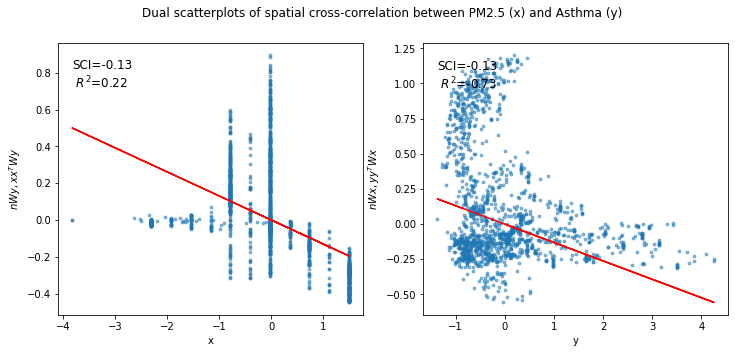

In [206]:
# plot
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
plt.scatter(x,n*contiguity_mat.dot(y),s=8,alpha=0.5)
# plt.scatter(x,x*x.T.dot(contiguity_mat.dot(y)),s=10,alpha=0.5)
plt.plot(x,x*rc1,'r-',label="trend line")
plt.text(min(x), max(n*contiguity_mat.dot(y))*0.8, 'SCI={:.2f}\n $R^2$={:.2f}'.format(rc1,rsq1), fontsize=12)
plt.xlabel('x')
plt.ylabel('$nWy,xx^TWy$')
# plt.title("scatterplot of {}".format(var1))

ax2 = plt.subplot(122)
plt.scatter(y,n*contiguity_mat.dot(x),s=8,alpha=0.5)
plt.plot(y,y*rc2,'r-',label="trend line")
plt.text(min(y), max(n*contiguity_mat.dot(x))*0.8, 'SCI={:.2f}\n $R^2$={:.2f}'.format(rc2,rsq2), fontsize=12)
plt.xlabel('y')
plt.ylabel('$nWx,yy^TWx$')
# plt.title("scatterplot of {}".format(var2))
plt.suptitle("Dual scatterplots of spatial cross-correlation between {} (x) and {} (y)".format(var1,var2))
pass

plt.savefig("dual_scatterplot_{}_vs_{}.png".format(var1,var2),bbox_inches='tight', )
files.download("dual_scatterplot_{}_vs_{}.png".format(var1,var2)) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

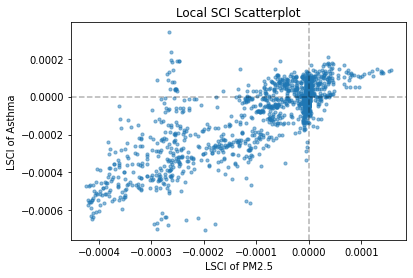

In [207]:
# LSCI (local SCI)
lsci1 = np.diag(np.matmul(np.matmul(x,y.T),contiguity_mat))
lsci2 = np.diag(np.matmul(np.matmul(y,x.T),contiguity_mat))
plt.figure()
plt.scatter(lsci1,lsci2,s=10,alpha=0.5)
plt.xlabel("LSCI of {}".format(var1))
plt.ylabel("LSCI of {}".format(var2))
plt.axvline(x=0,c=(0,0,0,0.3),ls='--')
plt.axhline(y=0,c=(0,0,0,0.3),ls='--')
plt.title('Local SCI Scatterplot')
plt.savefig("local_sci_{}_vs_{}.png".format(var1,var2),bbox_inches='tight', )
files.download("local_sci_{}_vs_{}.png".format(var1,var2)) 